# Usporedba performansi CNN, VGG16 i VGG19 modela na problemu klasifikacije vozila

Lucija Dumančić


Postupak preuzimanja skupa podataka s Kaggle platforme uključuje nekoliko koraka. Prvo je potrebno instalirati potrebne alate koji omogućuju interakciju s Kaggle API-jem. Nakon toga, prenosi se datoteka koja sadrži API ključeve za autentifikaciju kako bi se omogućio siguran pristup podacima. Ti ključevi se postavljaju na odgovarajuće mjesto na računalu, uz osiguravanje njihovih dozvola radi zaštite privatnosti. Nakon uspješne autentifikacije, putem Kaggle API-ja preuzima se željeni skup podataka. Na kraju, preuzeti podaci se raspakiraju i pripremaju za daljnju analizu i obradu.

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucijadumani","key":"32f97bfe822ae894ebd9b2ea02c5e2ea"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohamedmaher5/vehicle-classification

Dataset URL: https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification
License(s): CC0-1.0
100% 825M/827M [00:43<00:00, 17.3MB/s]
100% 827M/827M [00:43<00:00, 19.8MB/s]


In [ ]:
!unzip vehicle-classification.zip

Izlaz streaminga skraćen je na ovoliko posljednjih redaka: 5000.
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (630).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (631).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (632).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (633).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (634).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (635).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (636).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (637).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (638).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (639).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (64).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (640).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (641).jpg  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (642).JPG  
  inflating: Vehicles/Auto Rickshaws/Auto Rickshaw (64

Ovaj skup podataka namijenjen je za zadatke klasifikacije vozila i sadrži ukupno 5.600 slika raspoređenih u sedam kategorija. Svaka kategorija predstavlja različitu vrstu vozila, uključujući auto-rikše, bicikle, automobile, motocikle, avione, brodove i vlakove, s po 800 slika u svakoj kategoriji.

Korištene su razne biblioteke za obradu slika i razvoj modela strojnog učenja. Matplotlib omogućuje vizualizaciju podataka i rezultata, dok Numpy olakšava matematičke operacije nad podacima. PIL se koristi za obradu i manipulaciju slikama. Pathlib i shutil omogućuju rad s datotekama i direktorijima. TensorFlow zajedno s Kerasom služi za izgradnju i treniranje dubokih neuronskih mreža, posebno kroz upotebu slojeva kao što su Conv2D, MaxPooling2D, Flatten, Dense i BatchNormalization. VGG16 i VGG19 su unaprijed trenirane arhitekture modela koje se koriste za "transfer learning". ImageDataGenerator se koristi za augmentaciju slika. Scikit-learn omogućuje podjelu podataka na skupove za treniranje i testiranje, a Tqdm pruža vizualni prikaz napretka prilikom treniranja modela.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import pathlib
from pathlib import Path
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19

from sklearn.model_selection import train_test_split

from tqdm.keras import TqdmCallback

In [ ]:
dataset_url = "/content/Vehicles"
data_dir = pathlib.Path(dataset_url)

Identificiranje i ispis svih jedinstvenih ekstenzija datoteka koje su prisutne u skupu podataka, tako da se prolazi kroz sve datoteke u poddirektorijima. Zatim se broji ukupan broj datoteka koje su slike na temelju  specifičnih ekstenzija: .jpg, .png, .gif i .webp, uzimajući u obzir varijacije u velikim i malim slovima. Ukupan broj dobiva se zbrajanjem broja datoteka koje odgovaraju svakoj ekstenziji.

In [ ]:
all_files = list(data_dir.glob('*/*'))

file_extensions = set()

for file in all_files:
    file_extensions.add(file.suffix)

print("Unique file extensions in the dataset:")
for ext in file_extensions:
    print(ext)

Unique file extensions in the dataset:
.gif
.webp
.png
.JPG
.jpg
.PNG


In [ ]:
image_count = len(list(data_dir.glob('*/*.[jJ][pP][gG]'))) + \
              len(list(data_dir.glob('*/*.[pP][nN][gG]'))) + \
              len(list(data_dir.glob('*/*.[gG][iI][fF]'))) + \
              len(list(data_dir.glob('*/*.[wW][eE][bB][pP]')))

print(f"Total number of images: {image_count}")

Total number of images: 5590


Prolazi se kroz sve datoteke i pokušava otvoriti svaku od njih kako bi se utvrdilo je li slika ispravna ili  oštećena. Valjane slike se broje, dok se neispravne slike identificiraju i o njima se ispisuje informacija. Ova provjera je napravljena kako bi se ukupni broj slika prebrojan po ekstenzijama usporedio s ukupnim brojem ispravnih slika. Budući da se u opisu skupa podataka navodi da on sadrži 5 600 slika.

In [ ]:
valid_images = 0
for file in data_dir.glob('*/*'):
    try:
        img = Image.open(file)
        img.verify()
        valid_images += 1
    except (IOError, SyntaxError):
        print(f"Corrupt or invalid image: {file}")

print(f"Number of valid images: {valid_images}")

Number of valid images: 5590


Prikaz slika iz pojedine kategorije vozila.

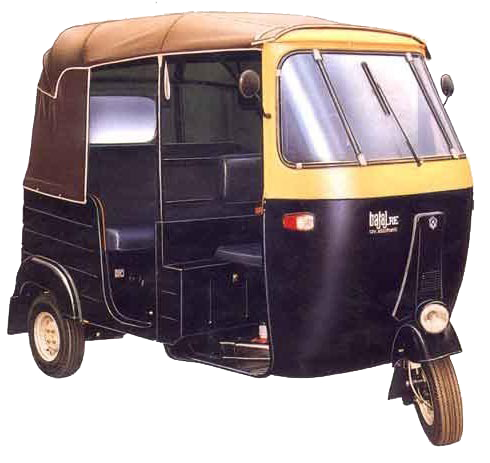

In [ ]:
Auto_rickshaws = list(data_dir.glob("Auto Rickshaws/*"))
PIL.Image.open(str(Auto_rickshaws[0]))

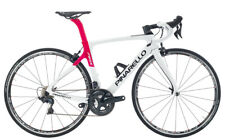

In [ ]:
Bikes = list(data_dir.glob("Bikes/*"))
PIL.Image.open(str(Bikes[0]))

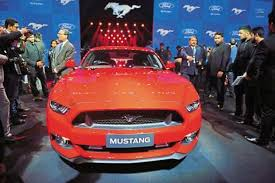

In [ ]:
Cars = list(data_dir.glob("Cars/*"))
PIL.Image.open(str(Cars[0]))

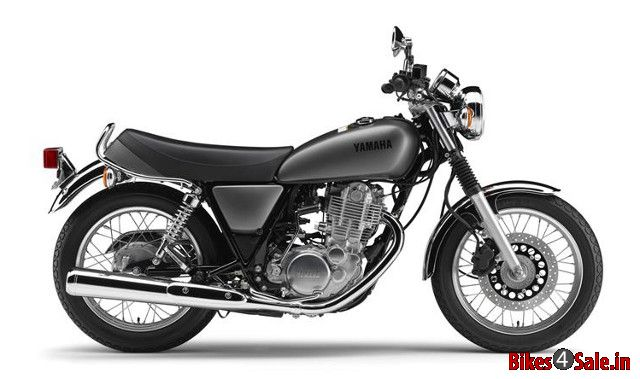

In [ ]:
Motorcycles = list(data_dir.glob("Motorcycles/*"))
PIL.Image.open(str(Motorcycles[0]))

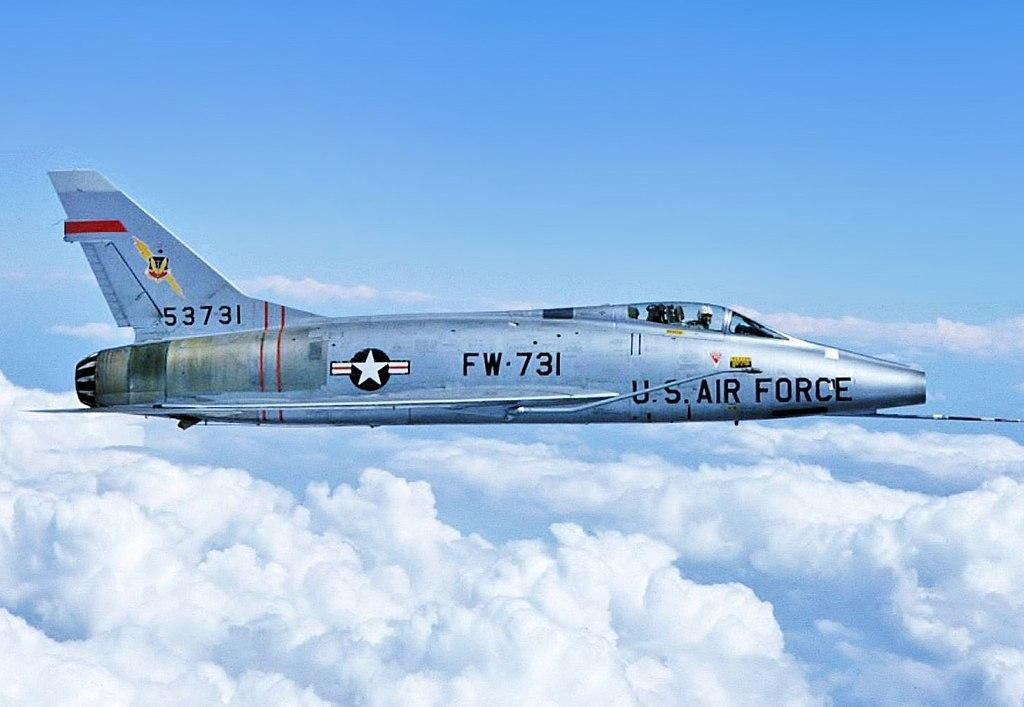

In [ ]:
Planes = list(data_dir.glob("Planes/*"))
PIL.Image.open(str(Planes[0]))

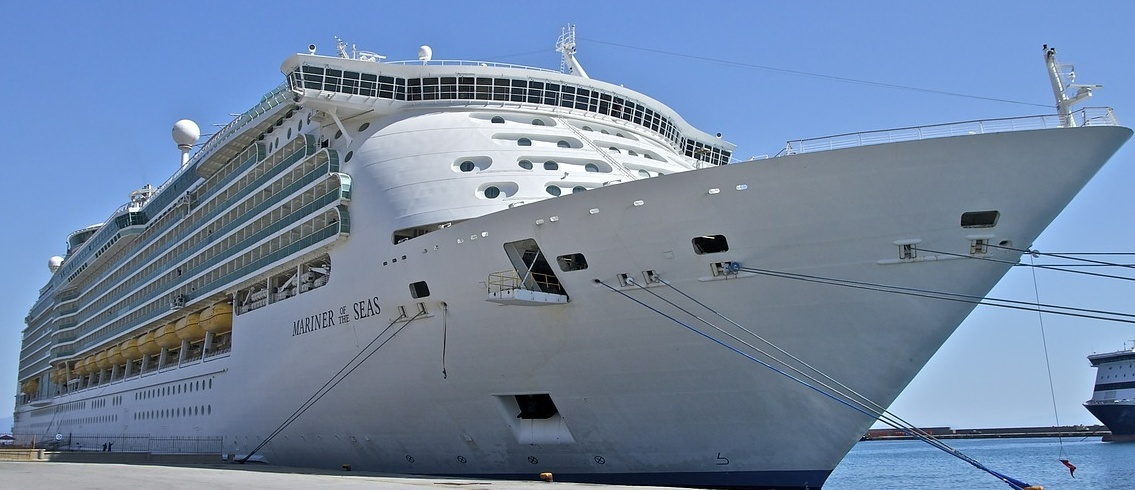

In [ ]:
Ships = list(data_dir.glob("Ships/*"))
PIL.Image.open(str(Ships[0]))

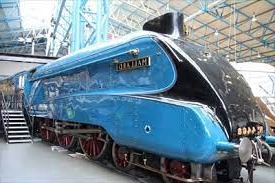

In [ ]:
Trains = list(data_dir.glob("Trains/*"))
PIL.Image.open(str(Trains[0]))

### Podjela skupa podataka

Razvrstavamo slike iz različitih kategorija vozila u zasebne skupove za treniranje, validaciju i testiranje te ih premještamo u odgovarajuće direktorije za svaku podjelu. Prvo se definira glavna mapa (`vehicles_split`) za podjelu podataka  te lista kategorija vozila. Zatim, za svaku kategoriju, dohvaćamo sve slike unutar odgovarajućeg direktorija i dijelimo ih pomoću funkcije `train_test_split`. Podaci se dijele na skup za treniranje (70 %), privremeni skup (30 %), koji se dalje dijeli na skup za validaciju i testiranje (po 15 % svaki). Funkcija `move_images` koristi se za premještanje slika u direktorije za treniranje, validaciju i testiranje unutar mape `vehicles_split`. Svaka odredišna mapa kreira se ako već ne postoji, a slike se kopiraju u nju koristeći biblioteku `shutil`, čime osiguravamo da izvorni skup podataka ostaje netaknut. Na kraju, ispisuje se poruka koja potvrđuje da su slike uspješno podijeljene i premještene u odgovarajuće direktorije.

In [ ]:
base_split_dir = Path("/content/vehicles_split")
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

for category in categories:
    category_path = data_dir / category
    images = list(category_path.glob('*'))

    # Split the images into train (70%), val (15%), and test (15%) sets
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    def move_images(image_list, destination):
        dest_path = base_split_dir / destination / category
        dest_path.mkdir(parents=True, exist_ok=True)  # Ensure the directory exists
        for image in image_list:
            shutil.copy(str(image), str(dest_path / image.name))

    move_images(train_images, "train")
    move_images(val_images, "val")
    move_images(test_images, "test")

print("Images have been split and moved to the appropriate directories.")

Images have been split and moved to the appropriate directories.


Funkcija `print_directory_structure` ispisuje strukturu direktorija počevši od zadanog glavnog direktorija. Funkcija koristi `Path` objekt iz biblioteke `pathlib` kako bi upravljala putanjama. Unutar funkcije, pomoću metode `rglob('*')`, pronalaze se svi direktoriji i poddirektoriji unutar glavnog direktorija, koji se potom sortiraju. Ako je pronađena stavka direktorija, računa se njena dubina u hijerarhiji direktorija, koja se koristi za određivanje uvlake prilikom ispisa. Uvlaka je proporcionalna razini na kojoj se direktorij nalazi. Na kraju, ispisuje se ime svakog direktorija, s odgovarajućom uvlakom, čime se vizualno prikazuje struktura direktorija.

In [ ]:
def print_directory_structure(root_dir):
    root_path = Path(root_dir)
    for dirpath in sorted(root_path.rglob('*')):
        if dirpath.is_dir():
            level = len(dirpath.relative_to(root_path).parts)
            indent = ' ' * 4 * level
            print(f"{indent}{dirpath.name}/")

print("\nDirectory structure after splitting:")
print_directory_structure(base_split_dir)


Directory structure after splitting:
    test/
        Auto Rickshaws/
        Bikes/
        Cars/
        Motorcycles/
        Planes/
        Ships/
        Trains/
    train/
        Auto Rickshaws/
        Bikes/
        Cars/
        Motorcycles/
        Planes/
        Ships/
        Trains/
    val/
        Auto Rickshaws/
        Bikes/
        Cars/
        Motorcycles/
        Planes/
        Ships/
        Trains/


### ImageDataGenerator

Postavljanje generatora slika za treniranje, validaciju i testiranje modela, koristeći `ImageDataGenerator` iz Keras biblioteke. Generatori omogućuju učitavanje slika iz direktorija, njihovu augmentaciju, reskaliranje piksela i učitavanje podataka u grupama, što je ključno za rad s velikim skupovima podataka koji ne mogu stati u memoriju odjednom.


`ImageDataGenerator` se koristi za generiranje varijacija originalnih slika kroz različite transformacije, odnosno augmentaciju slika. Ovaj proces umjetno povećava raznolikost skupa podataka, što pomaže modelu da generalizira bolje i izbjegne prekomjerno prilagođavanje (overfitting) na skup za treniranje.


*   `rescale = 1./255`: Vrijednosti piksela slika su inicijalno u rasponu od 0 do 255. Ova postavka normalizira te vrijednosti u rasponu od 0 do 1, što omogućuje bržu i stabilniju konvergenciju tijekom treniranja modela.
*  ` rotation_range=20`: Slike mogu biti nasumično rotirane unutar raspona od -20 do 20 stupnjeva. To pomaže modelu da postane otporniji na različite orijentacije objekata.
* `width_shift_range=0.2` i` height_shift_range=0.2`: Pomicanje slike po širini i visini do 20 % od njezine originalne veličine. Ovo simulira razne scenarije gdje objekt može biti blago pomaknut unutar slike, pomažući modelu da nauči prepoznati objekte bez obzira na njihovu poziciju.
* `shear_range=0.2`: Smicanje slike pod kutom do 20%, što stvara efekt "ispružene" slike i pomaže modelu da nauči prepoznavati deformirane objekte.
* `zoom_range=0.2`: Zumiranje slike do 20%, što pomaže modelu da prepozna objekte na različitim udaljenostima ili veličinama.
* `horizontal_flip=True`: Slike se nasumično okrenu horizontalno, što je korisno ako su objekti u skupu podataka simetrični (npr. vozila koja mogu biti okrenuta u različitim smjerovima).

Ova augmentacija je korisna isključivo u treniranju, jer se model trenira na varijantama slika, što poboljšava njegovu sposobnost generalizacije.

Za validacijske i testne skupove koristi se samo normalizacija slika pomoću `rescale = 1./255`, bez dodatnih transformacija. Razlog je to što validacija i testiranje moraju ocjenjivati model na "čistim" podacima, tj. bez ikakvih dodatnih promjena koje bi mogle utjecati na točnost rezultata.

Zatim se definiraju direktoriji za trenirane, validacijske i testne skupove (`train_dir`, `val_dir` i `test_dir`), a slike iz tih direktorija učitavaju se pomoću generatora `flow_from_directory`. Ovi generatori uzimaju slike iz pripadajućih direktorija, mijenjaju veličinu slika na 150x150 piksela, grupiraju ih po 64 slike (`batch_size=64`), te ih kategoriziraju prema klasama koje su navedene u varijabli `categories`. Svaki od generatora koristi `class_mode='categorical'`, što znači da su ciljne varijable klasificirane u više kategorija, a sve slike su organizirane u odgovarajuće kategorije (npr. automobili, bicikli, avioni).



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = base_split_dir / "train"
val_dir = base_split_dir / "val"
test_dir = base_split_dir / "test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    classes=categories
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    classes=categories
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    classes=categories
)

Found 3911 images belonging to 7 classes.
Found 838 images belonging to 7 classes.
Found 838 images belonging to 7 classes.


Prikaz devet slika iz skupa za treniranje zajedno s pripadajućim klasama.

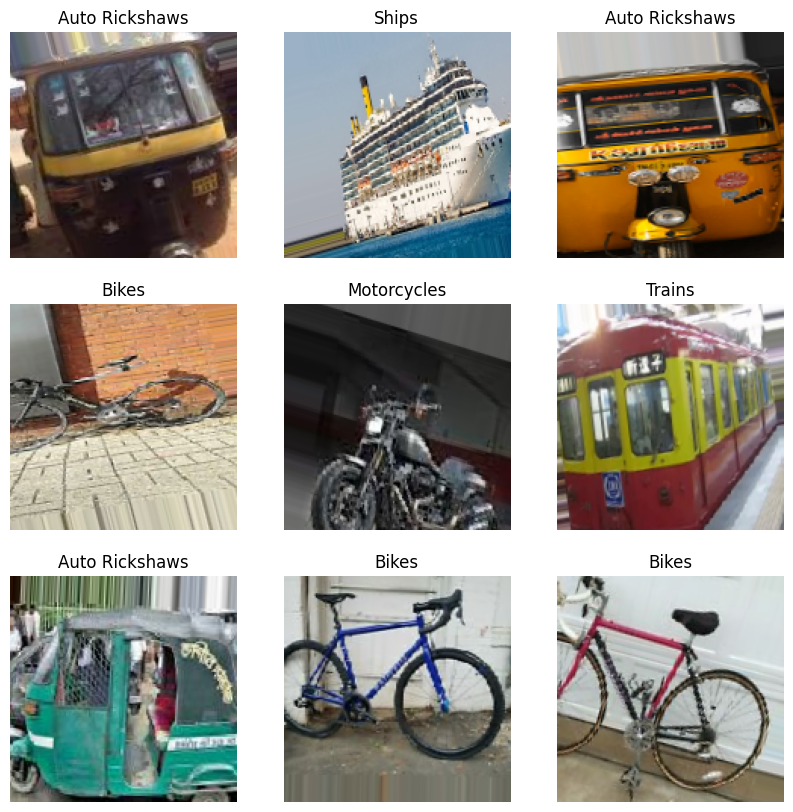

In [ ]:
images, labels = next(train_generator)

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

plt.show()

### CNN Model

Arhitektura CNN mreže:
* **Tri konvolucijska sloja**: 32, 64, 128 filtera (3x3), svaki s ReLU aktivacijskom funkcijom i MaxPooling (2x2) slojem nakon svake konvolucije.
* **Flatten sloj**: Poravnava 3D značajke u 1D vektor
* **Potpuno povezani sloj**: 128 neurona s ReLU aktivacijskom funkcijom i Dropout (50%) radi sprječavanja prenaučenosti.
* **Izlazni sloj**: Softmax aktivacijska funkcija za klasifikaciju u 7 kategorija.

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

Parametar `input_shape = (150, 150, 3)` definira dimenzije ulaznih slika kao 150x150 piksela s 3 kanala boje (RGB), dok `num_classes = len(categories)` postavlja broj izlaznih klasa na duljinu popisa `categories`, koji predstavlja različite kategorije vozila.

In [ ]:
input_shape = (150, 150, 3)
num_classes = len(categories)

Kompajlira se CNN model sa sljedećim parametrima:
* Optimizator Adam sa stopom učenja 0.001.
* Funkcija gubitka je kategorička unakrsna entropija
* Točnost se koristi za procjenu performansi modela

Adam optimizator koristi se za podešavanje težina modela tijekom treniranja kako bi se minimizirala funkcija gubitka. Manja stopa učenja osigurava da model pravi manje korake prema minimiziranju gubitka.Zadana stopa učenja za Adam je obično 0.001.

Kategorička unakrsna entropija je prikladna za probleme višeklasne klasifikacije gdje svaki uzorak pripada jednoj od nekoliko kategorija. Mjeri razliku između predviđene distribucije vjerojatnosti i stvarne distribucije. Cilj je minimizirati ovu razliku tijekom treniranja.


In [ ]:
cnn_model = create_cnn_model(input_shape, num_classes)

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN model se trenira koristeći `train_generator` tijekom 30 epoha, evaluirajući njegovu izvedbu nakon svake epohe na `val_generator` (validacijski podaci). `TqdmCallback` pruža traku napretka za praćenje treniranja u stvarnom vremenu.

In [ ]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/62 ━━━━━━━━━━━━━━━━━━━━ 6s 716ms/step - accuracy: 0.2119 - loss: 1.9800

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 63s 816ms/step - accuracy: 0.2219 - loss: 1.9545 - val_accuracy: 0.3914 - val_loss: 1.5927
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 736ms/step - accuracy: 0.4391 - loss: 1.5503 - val_accuracy: 0.4964 - val_loss: 1.3472
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 723ms/step - accuracy: 0.5226 - loss: 1.3276 - val_accuracy: 0.6945 - val_loss: 0.9453
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 736ms/step - accuracy: 0.5482 - loss: 1.2359 - val_accuracy: 0.6456 - val_loss: 1.0347
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 716ms/step - accuracy: 0.5946 - loss: 1.1266 - val_accuracy: 0.7220 - val_loss: 0.8092
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 725ms/step - accuracy: 0.6341 - loss: 1.0243 - val_accuracy: 0.6897 - val_loss: 0.8687
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 733ms/step - accuracy: 0.6401 - loss: 1.0274 - val_accuracy: 0.7196 - val_loss: 0.7927
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 729ms/step - accuracy: 0.6807 - loss: 0.9074 - val_accuracy: 0.747

Evaluacija istreniranog CNN modela na testnom skupu podataka koristeći `test_generator`, izračunavajući gubitak i točnost na testnim podacima.

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f"Test Accuracy for CNN: {test_acc * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.8233 - loss: 0.5409
Test Accuracy for CNN: 82.58%


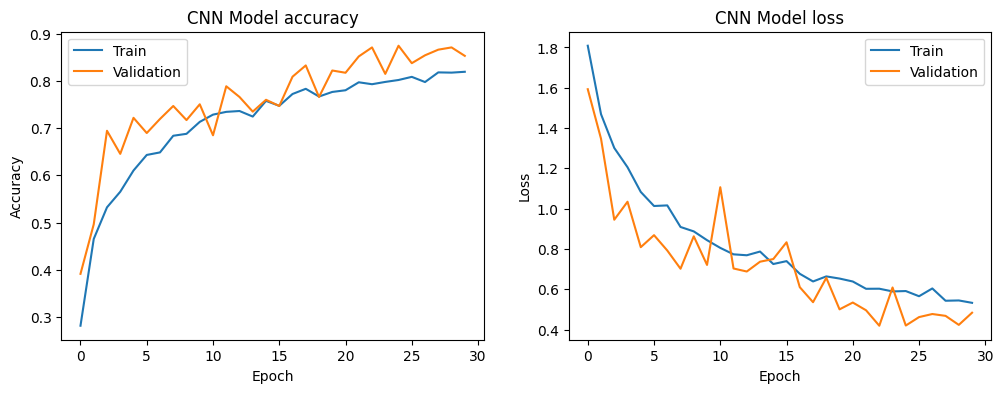

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.show()

Ova dva grafa prikazuju trendove točnosti i gubitka CNN modela tijekom 30 epoha za oba skupa podataka, trening i validacijski. Točnost na podacima za treniranje počinje nisko, ali se postupno povećava kako model uči, dostižući oko 80%.
Točnost validacije također počinje nisko ali brzo raste i fluktuira kroz ostatak epoha. Fluktuacija ukazuje na neku varijabilnost između epoha, što je uobičajeno u rezultatima validacije zbog manjeg uzorka i različitih karakteristika podataka u odnosu na skup za treniranje. Gubitak pri treniranju počinje visoko i brzo pada u prvih nekoliko epoha, nastavljajući lagano padati i stabilizirajući se oko 0.6. Ovaj pad u gubitku označava da model učinkovito smanjuje greške tijekom epoha. Slično kao i točnost validacije, gubitak pri validaciji brzo pada na početku, ali zatim pokazuje fluktuacije.
Konačna točnost na podacima za testiranje od 82.58% sugerira da model dobro funkcionira na neviđenim podacima.

Prikaz 9 slika, gdje svaka slika predstavlja vozilo iz testnog skupa. Iznad svake slike prikazane su točna oznaka i predviđena oznaka.

In [ ]:
def plot_predictions(generator, model, num_images=9):
    images, true_labels = next(generator)

    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis("off")

    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


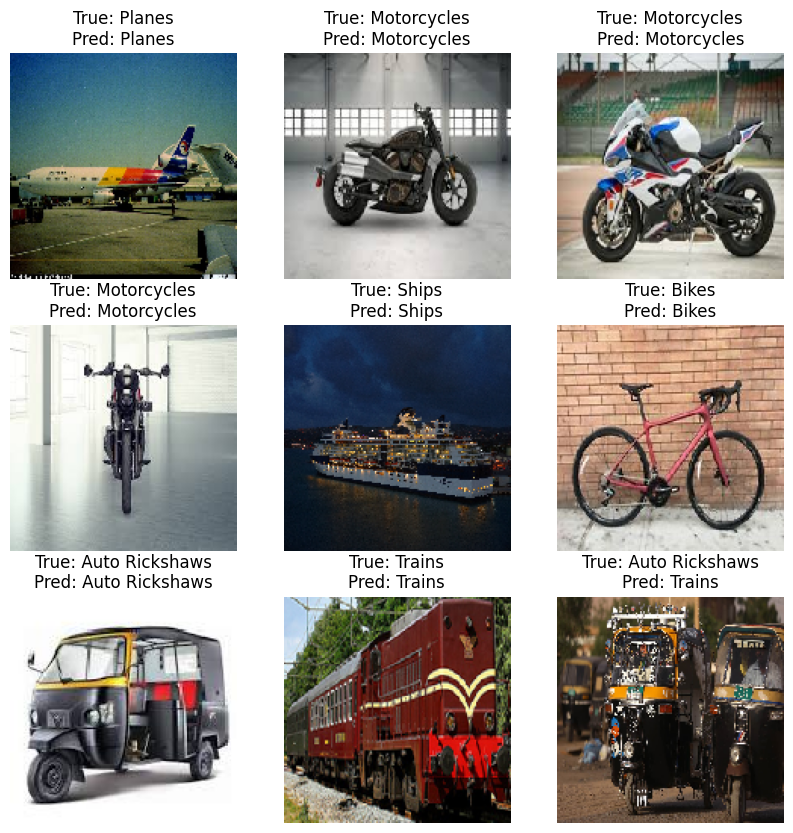

In [ ]:
plot_predictions(test_generator, cnn_model)

### VGG16 Model

VGG16 je poznata duboka CNN arhitektura koja je trenirana na ImageNet skupu podataka, koji sadrži milijune slika iz 1000 različitih kategorija. Parametar `weights='imagenet'` znači da će model koristiti unaprijed istrenirane težine s ImageNet skupa podataka, što omogućava iskorištavanje značajki naučenih na tom velikom skupu podataka. `include_top=False` isključuje potpuno povezane (klasifikacijske) slojeve na vrhu VGG16 arhitekture jer želimo podesiti model za klasifikaciju vozila, a ne za originalnih 1000 klasa iz ImageNeta. `input_shape` specificira oblik ulaznih slika, koji mora biti kompatibilan s VGG16.

Zamrzavanje baznog modela znači da slojevi u unaprijed istreniranom VGG16 modelu neće biti ažurirani tijekom treniranja. Ovo sprječava modificiranje težina tih slojeva i čuva već naučene značajke. Zamrzavanjem baznog modela, trenirat će se samo novododani slojevi, što smanjuje vrijeme treniranja i rizik od prenaučenosti na manjim skupovima podataka.

Nakon VGG16 baze, dodaju se dodatni slojevi kako bi se model prilagodio specifičnom zadatku klasifikacije:
* Flatten sloj poravnava izlaz iz konvolucijskih slojeva VGG16 u 1D vektor, koji se zatim može proslijediti potpuno povezanim slojevima za klasifikaciju.
* Potpuno povezani sloj s 512 neurona i ReLU aktivacijskom funkcijom uči složene kombinacije značajki izvučenih iz VGG16 baze.
* Nasumičnim "ispuštanjem" 30% neurona tijekom treniranja sprječava se prenaučenost i model bolje generalizira na nove podatke.
* Izlazni sloj koristi softmax funkciju za izračunavanje vjerojatnosti za svaku od 7 kategorija.

VGG16 model se kompajlira s istim parametrima kao i CNN model uz manju stopu učenju (0.0001).

In [ ]:
def create_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

VGG16 model se trenira 20 epoha.

In [ ]:
model_vgg16 = create_vgg16_model(input_shape, num_classes)

history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 70s 841ms/step - accuracy: 0.4843 - loss: 1.3751 - val_accuracy: 0.8974 - val_loss: 0.3494
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 742ms/step - accuracy: 0.8017 - loss: 0.5795 - val_accuracy: 0.9105 - val_loss: 0.2716
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 758ms/step - accuracy: 0.8525 - loss: 0.4316 - val_accuracy: 0.9177 - val_loss: 0.2376
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 747ms/step - accuracy: 0.8782 - loss: 0.3618 - val_accuracy: 0.9308 - val_loss: 0.2049
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.8920 - loss: 0.3411 - val_accuracy: 0.9320 - val_loss: 0.2056
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 727ms/step - accuracy: 0.8864 - loss: 0.3213 - val_accuracy: 0.9344 - val_loss: 0.1921
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 732ms/step - accuracy: 0.8996 - loss: 0.3007 - val_accuracy: 0.9356 - val_loss: 0.1721
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 723ms/step - accuracy: 0.9035 - loss: 0.2834 - val_accu

Evaluacija na podacima za testiranje.

In [ ]:
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator)
print(f"Test accuracy for VGG16: {test_acc_vgg16 * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9274 - loss: 0.1920
Test accuracy for VGG16: 93.20%


#### Fine-Tuning VGG16 Model

Ovaj proces uključuje fino podešavanje (fine-tuning) unaprijed istreniranog VGG16 modela otključavanjem njegovih slojeva i ponovnim treniranjem cijelog modela, uključujući unaprijed istreniranu bazu, s puno manjom stopom učenja.

U početnom treniranju bazni model je bio zamrznut, što znači da unaprijed istrenirane težine nisu bile ažurirane. Ovdje `base_model.trainable = True` otključava slojeve VGG16, omogućujući njihovo ažuriranje tijekom treniranja. To omogućuje modelu da fino podešava unaprijed istrenirane težine kako bi se bolje prilagodio novom zadatku klasifikacije.

Model se ponovo kompajlira s vrlo malom stopom učenja (0.00001). Niža stopa učenja je ključna prilikom finog podešavanja unaprijed istreniranih modela kako bi se izbjegle drastične promjene u naučenim težinama, što bi moglo dovesti do zaboravljanja prethodno naučenih korisnih značajki (fenomen poznat kao "katastrofalno zaboravljanje"). Ostali parametri ostaju isti kao i u prethodnom kompajliranju modela.

Model se fino podešava ponovnim treniranjem tijekom 20 dodatnih epoha. Ovaj put, ažuriraju se i bazni VGG16  slojevi kao i novo dodani slojevi. Fino podešavanje omogućuje modelu da bolje uči specifične značajke novog skupa podataka, poboljšavajući njegove performanse.



In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg16_fine = model_vgg16.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 54s 759ms/step - accuracy: 0.9371 - loss: 0.1848 - val_accuracy: 0.9558 - val_loss: 0.1376
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 738ms/step - accuracy: 0.9492 - loss: 0.1610 - val_accuracy: 0.9535 - val_loss: 0.1394
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 752ms/step - accuracy: 0.9354 - loss: 0.1883 - val_accuracy: 0.9558 - val_loss: 0.1349
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 743ms/step - accuracy: 0.9477 - loss: 0.1605 - val_accuracy: 0.9558 - val_loss: 0.1335
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 747ms/step - accuracy: 0.9473 - loss: 0.1728 - val_accuracy: 0.9570 - val_loss: 0.1373
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 707ms/step - accuracy: 0.9496 - loss: 0.1638 - val_accuracy: 0.9558 - val_loss: 0.1303
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 759ms/step - accuracy: 0.9469 - loss: 0.1554 - val_accuracy: 0.9558 - val_loss: 0.1317
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 728ms/step - accuracy: 0.9384 - loss: 0.1806 - val_accu

Evaluacija modela na testnim podacima nakon finog podešavanja.

In [ ]:
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator)
print(f"Test accuracy for VGG16: {test_acc_vgg16 * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.9395 - loss: 0.1691
Test accuracy for VGG16: 94.39%


In [ ]:
model_vgg16.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,309,911 (104.18 MB)

 Trainable params: 4,198,407 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 8,396,816 (32.03 MB)

Prikaz rezultata predikcije VGG16 modela na testnim podacima, uspoređujući točne oznake s predviđenim oznakama.

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step


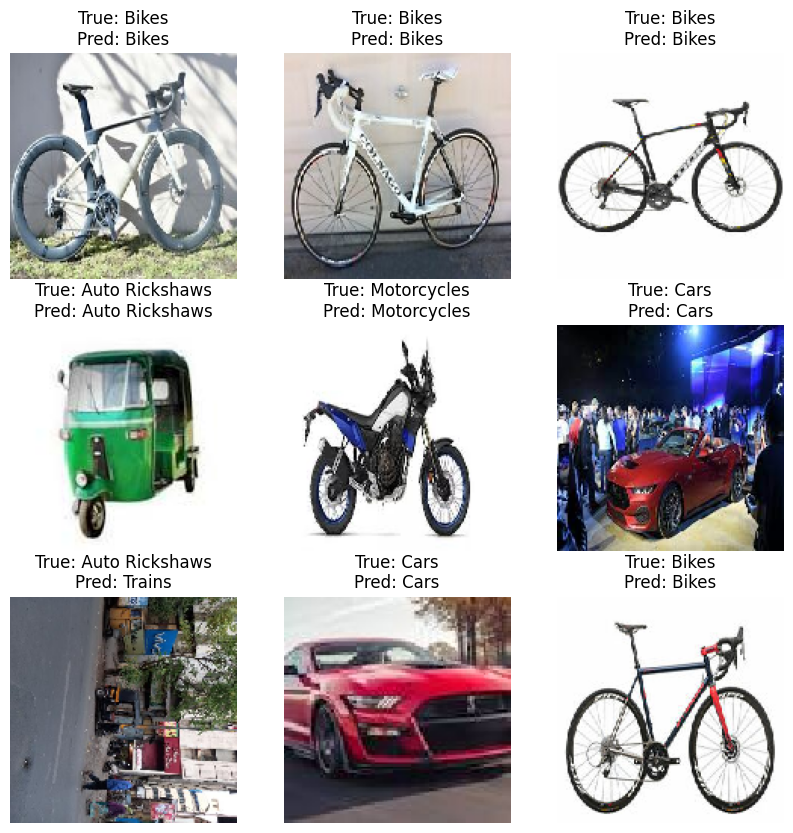

In [ ]:
plot_predictions(test_generator, model_vgg16)

### VGG19 Model

VGG19 je proširena verzija VGG arhitekture s 19 slojeva (16 konvolucijskih slojeva i 3 potpuno povezana sloja). Parametri ovog modela, kao i sam proces treniranja je isti kao i kod VGG16 modela.

In [ ]:
def create_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model_vgg19 = create_vgg19_model(input_shape, num_classes)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model_vgg19 = create_vgg19_model(input_shape, num_classes)

history_vgg19 = model_vgg19.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 732ms/step - accuracy: 0.4399 - loss: 1.5604 - val_accuracy: 0.8496 - val_loss: 0.4576
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 52s 762ms/step - accuracy: 0.7842 - loss: 0.6235 - val_accuracy: 0.8854 - val_loss: 0.3226
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 759ms/step - accuracy: 0.8289 - loss: 0.4987 - val_accuracy: 0.9129 - val_loss: 0.2743
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 734ms/step - accuracy: 0.8369 - loss: 0.4610 - val_accuracy: 0.9105 - val_loss: 0.2644
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 714ms/step - accuracy: 0.8649 - loss: 0.4037 - val_accuracy: 0.9189 - val_loss: 0.2483
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 737ms/step - accuracy: 0.8623 - loss: 0.3967 - val_accuracy: 0.9403 - val_loss: 0.2196
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 730ms/step - accuracy: 0.8823 - loss: 0.3373 - val_accuracy: 0.9284 - val_loss: 0.2164
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 747ms/step - accuracy: 0.8876 - loss: 0.3326 - val_accu

In [ ]:
test_loss_vgg19, test_acc_vgg19 = model_vgg19.evaluate(test_generator)
print(f"Test accuracy for VGG19: {test_acc_vgg19 * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.9321 - loss: 0.2014
Test accuracy for VGG19: 93.91%


#### Fine-Tuning VGG19 Model

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True

model_vgg19.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg19_fine = model_vgg19.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 55s 765ms/step - accuracy: 0.9209 - loss: 0.2330 - val_accuracy: 0.9570 - val_loss: 0.1532
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 742ms/step - accuracy: 0.9228 - loss: 0.2292 - val_accuracy: 0.9570 - val_loss: 0.1523
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 757ms/step - accuracy: 0.9276 - loss: 0.2106 - val_accuracy: 0.9511 - val_loss: 0.1538
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 50s 717ms/step - accuracy: 0.9274 - loss: 0.2026 - val_accuracy: 0.9523 - val_loss: 0.1553
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 746ms/step - accuracy: 0.9265 - loss: 0.2138 - val_accuracy: 0.9582 - val_loss: 0.1519
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 744ms/step - accuracy: 0.9162 - loss: 0.2281 - val_accuracy: 0.9535 - val_loss: 0.1497
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 757ms/step - accuracy: 0.9202 - loss: 0.2168 - val_accuracy: 0.9570 - val_loss: 0.1505
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 51s 753ms/step - accuracy: 0.9367 - loss: 0.1987 - val_accu

In [ ]:
test_loss_vgg19, test_acc_vgg19 = model_vgg19.evaluate(test_generator)
print(f"Test accuracy for VGG19: {test_acc_vgg19 * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 376ms/step - accuracy: 0.9508 - loss: 0.1610
Test accuracy for VGG19: 94.63%


In [ ]:
model_vgg19.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,619,607 (124.43 MB)

 Trainable params: 4,198,407 (16.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 8,396,816 (32.03 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 


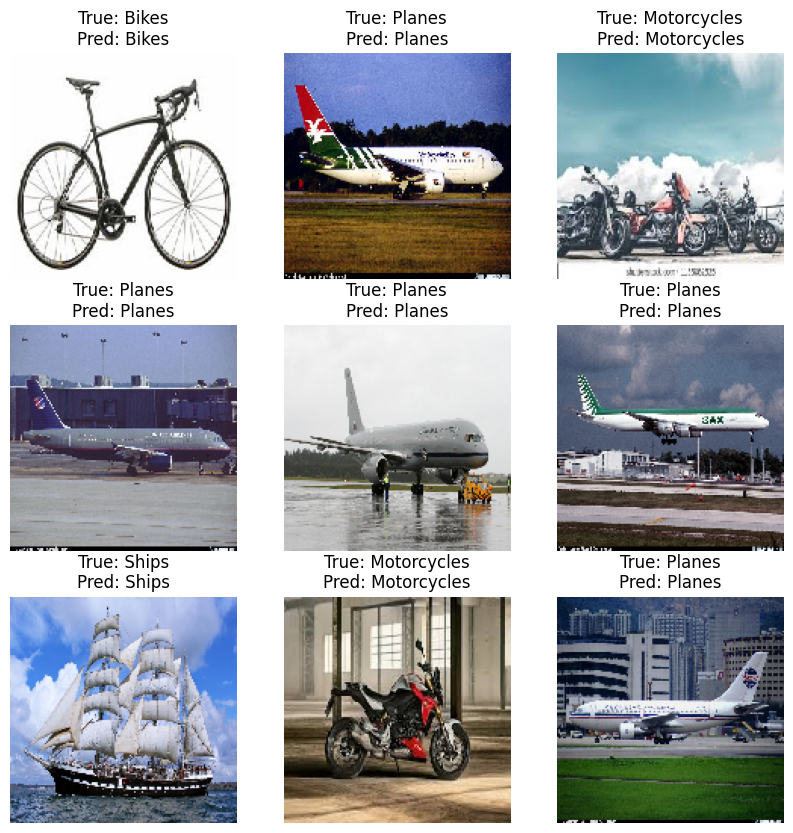

In [ ]:
plot_predictions(test_generator, model_vgg19)

### Zaključak

Usporedba performanski modela na testnom skupu podataka:
* CNN: 82.58%
* VGG16 prije fine-tuninga: 93.20%
* VGG16 nakon fine-tuninga: 94.39%
* VGG19 prije fine-tuninga: 93.91%
* VGG19 nakon fine-tuninga: 94.63%

CNN model postigao je točnost od 82.58%, što je znatno niže u usporedbi s točnostima unaprijed istreniranih VGG16 i VGG19 modela. Ovaj rezultat je očekivan s obzirom na to da su VGG modeli unaprijed trenirani na ImageNet skupu podataka, koji sadrži milijune slika u 1000 kategorija, što im daje veliku sposobnost učenja i ekstrakcije značajki. S druge strane, CNN model je treniran od početka na specifičnom skupu podataka za klasifikaciju vozila, te nije imao prednost korištenja prethodno naučenih značajki, što je rezultiralo slabijom izvedbom.
Razlike u performansama između VGG16 i VGG19 su relativno male, ali nakon fine-tuninga VGG19 postiže najbolju točnost od 94.63%, dok VGG16 postiže nešto nižih 94.39%. Ova razlika pokazuje da veća dubina VGG19 modela može pružiti blagu prednost u složenijim zadacima klasifikacije, kao što je klasifikacija vozila. Unatoč tome, obje verzije VGG modela pružaju značajnu prednost u odnosu na osnovni CNN model.
Rezultati pokazuju da korištenje unaprijed istreniranih modela kao što su VGG16 i VGG19, uz fino podešavanje, značajno poboljšava točnost u klasifikaciji vozila u usporedbi s treniranjem modela od početka. Transferno učenje se pokazalo kao vrlo učinkovito sredstvo za postizanje visokih performansi u zadacima klasifikacije s ograničenim skupovima podataka, pri čemu VGG19 nudi najbolju ukupnu izvedbu nakon fine-tuninga.


